In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
# from xmovie import Movie
import nfft
# import xrft
import cmath
import matplotlib as mpl
from matplotlib.lines import Line2D
import math
from math import radians, cos, sin, asin, sqrt
# import eofs.xarray as xeof
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%run Code_functions.ipynb
%matplotlib inline

# Load Data

In [2]:
input_path = 'E:/for_hendrik_20230316/'
# input_path = '/home/hgrosselindemann/Documents/TORI/'
figure_path = '/Users/2311043/Documents/GitHub/TORI/figures/'
# velocity = xr.open_mfdataset(input_path + 'velocity_raw_detrended.nc')

# velocity = xr.open_dataset(input_path + 'velocity_raw_filtered.nc')



# spectral_u = xr.open_dataset(input_path + 'spectral_u.nc')
# spectral_u['f_k'] = spectral_u.f_k_real + 1j*spectral_u.f_k_imag

# spectral_v = xr.open_dataset(input_path + 'spectral_v.nc')
# spectral_v['f_k'] = spectral_v.f_k_real + 1j*spectral_v.f_k_imag

# spectral_rotary = xr.open_dataset(input_path + 'spectral_rotary.nc')
# spectral_rotary['f_k'] = spectral_rotary.f_k_real + 1j*spectral_rotary.f_k_imag

bathy = xr.open_dataset(input_path + 'etopo5.cdf')
bathy = bathy.rename({'ETOPO05_X':'lon','ETOPO05_Y':'lat'})
bathy = bathy.where(bathy.ROSE<=0)

In [2]:
# input_path = '/home/hgrosselindemann/Documents/for_hendrik_20230316/'

# input_path = '/Users/2311043/Documents/GitHub/TORI/'
input_path = 'E:/for_hendrik_20230316/'

grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
# vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [3]:
time = np.arange(datetime(2013,1,1,0,0,0), datetime(2018,1,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [8]:
files = []
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
for year in np.arange(2013,2018):
    for month in months:

        files.append(input_path + 'raw_data/' + f'{year}{month}.mat')

In [9]:
vel_u = scipy.io.loadmat(files[0])['u0_monthly']
vel_v = scipy.io.loadmat(files[0])['v0_monthly']


for file in files[1:]:
    u = scipy.io.loadmat(file)['u0_monthly']
    v = scipy.io.loadmat(file)['v0_monthly']
    
    vel_u = np.concatenate((vel_u,u),axis=-1)
    vel_v = np.concatenate((vel_v,v),axis=-1)    

In [10]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],time)
},data_vars={
    'u':(['y','x','time'],vel_u/100),
    'v':(['y','x','time'],vel_v/100)
})

velocity = velocity.transpose('time','y','x')

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)
velocity['abs'] = np.sqrt(velocity['u']**2 + velocity['v']**2)

# means

In [392]:
u_dashed = velocity.u - velocity.u.mean(dim='time')
v_dashed = velocity.v - velocity.v.mean(dim='time')

eke_mean = ((u_dashed**2).mean(dim='time') + (v_dashed**2).mean(dim='time'))/2

In [11]:
eke = (velocity.u**2 + velocity.v**2)/2 - (velocity.u.mean(dim='time')**2 + velocity.v.mean(dim='time')**2)/2

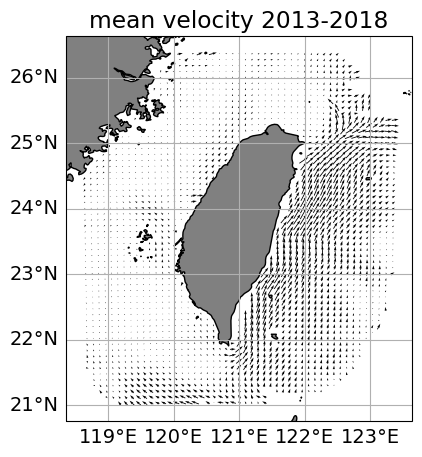

In [89]:
# fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

# eke_mean.plot(ax=ax1,x='lon',y='lat',cmap=cmo.amp,cbar_kwargs={'label':'EKE'})
velocity.mean(dim='time').plot.quiver('lon','lat','u','v',ax=ax1,add_guide=False)
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False
ax1.set_title('mean velocity 2013-2018')
plt.savefig(figure_path + 'mean_velocity.png')

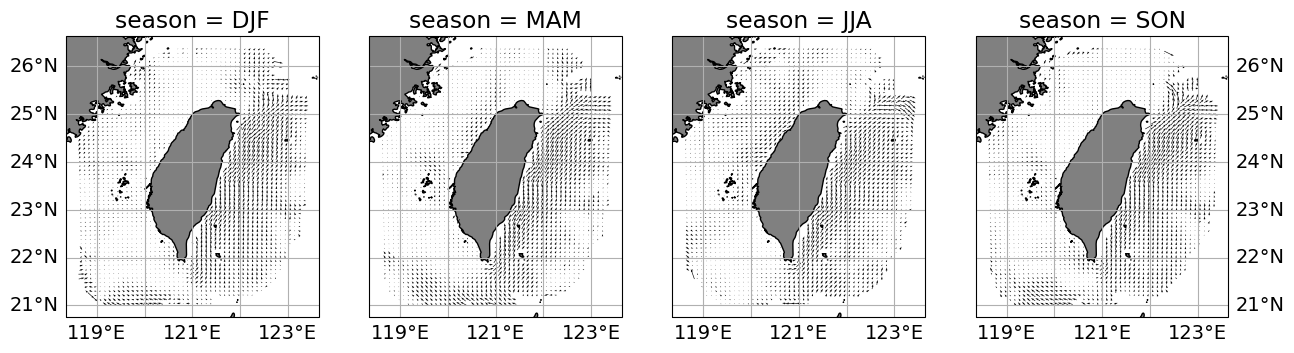

In [90]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

season_mean = velocity.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','u','v',ax=ax1,add_guide=False)
season_mean.sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax2,add_guide=False)
season_mean.sel(season='JJA').plot.quiver('lon','lat','u','v',ax=ax3,add_guide=False)
season_mean.sel(season='SON').plot.quiver('lon','lat','u','v',ax=ax4,add_guide=False)

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
gl2.left_labels=False

ax3.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels=False
gl3.right_labels=False
gl3.left_labels=False

ax4.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels=False
gl4.left_labels=False

plt.savefig(figure_path + 'seasonal_means.png')

# Data Coverage

In [76]:
nan_mask = ~np.isnan(velocity.u)
data_coverage = np.sum(nan_mask,axis=0)/len(velocity.time)
velocity['coverage'] = data_coverage

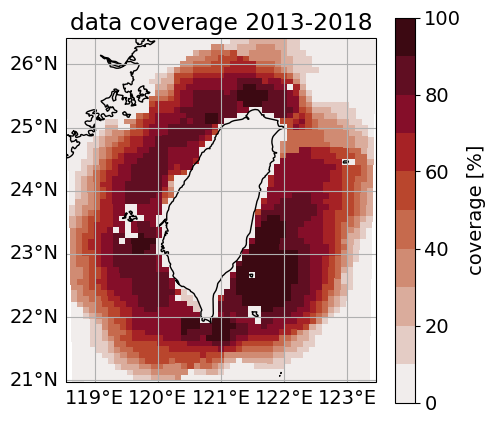

In [8]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1,x='lon',y='lat',levels=np.arange(0,110,10),cmap=cmo.amp,cbar_kwargs={'label':'coverage [%]'})

# ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

# for x,y in zip(x_idx,y_idx):
#     xr.plot.scatter(ds=velocity.isel(x=x,y=y),x='lon',y='lat',color='b')
# xr.plot.scatter(ds=velocity.isel(x=28,y=10),x='lon',y='lat')
# plt.scatter(longitudes,latitudes,transform=ccrs.PlateCarree(),marker='x')

ax1.set_title('data coverage 2013-2018')
plt.savefig(figure_path + 'data_coverage.png')

# De-mean and De-trend

In [54]:
velocity['u_demeaned'],velocity['u_mean'] = demean_xarray(velocity.u,dim='time')
velocity['v_demeaned'],velocity['v_mean'] = demean_xarray(velocity.v,dim='time')

In [63]:
velocity['u_detrended'],velocity['u_trend'] = detrend_xarray(velocity['u_demeaned'])
velocity['v_detrended'],velocity['v_trend'] = detrend_xarray(velocity['v_demeaned'])

In [65]:
velocity.to_netcdf(input_path + 'velocity_raw_detrended.nc')

# interpolation

In [22]:
test = velocity.u[:,10,10].copy()
dummy = test.interpolate_na(dim='time',method='linear')

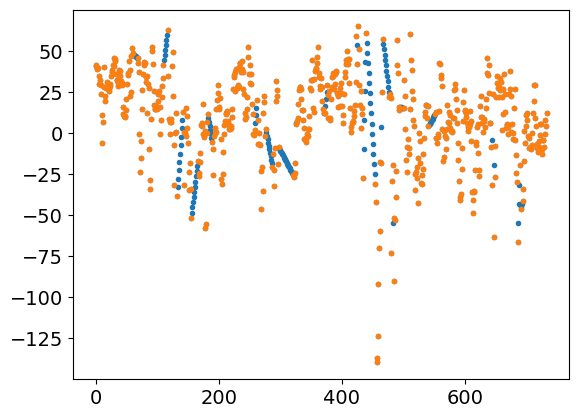

In [23]:
plt.plot(dummy,'.')
plt.plot(test,'.')


# Spectral analysis

## uniform FFT

In [6]:
# try xrft.power_spectrum

In [36]:
mask = ~np.isnan(u_detrended[:,10,10].interpolate_na(dim='time',method='linear'))
freq,ps,psd = spectrum1(u_detrended[:,10,10].interpolate_na(dim='time',method='linear')[mask])

## non-uniform FFT

In [5]:
# spectral_u = spectral_analysis(velocity.u_detrended)
spectral_v = spectral_analysis(velocity.v_detrended)

spectral_v = spectral_v.where(spectral_v!=0)

spectral_v_nocomplex = spectral_v.copy()

spectral_v_nocomplex['f_k_real'] = np.real(spectral_v_nocomplex.f_k)
spectral_v_nocomplex['f_k_imag'] = np.imag(spectral_v_nocomplex.f_k)

spectral_v_nocomplex = spectral_v_nocomplex.drop(['f_k'])

spectral_v_nocomplex.to_netcdf(input_path + 'spectral_v.nc')

In [60]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,12,28],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,data_reconstructed_filtered = nufft(velocity.u_filtered[:,12,28],xarray_apply=False)

In [70]:
freq_hann,f_k_hann,ps_hann,psd_hann,t_hann = nufft(velocity.v_detrended[:,12,28],xarray_apply=False)

In [20]:
freq_pos = freq[372:]

f_k_pos = np.ones((372))*f_k[372:]
f_k_pos[1:] = f_k_pos[1:]*2

ps_pos = np.ones((372))*ps[372:]
ps_pos[1:] = ps_pos[1:]*2

psd_pos = np.ones((372))*psd[372:]
psd_pos[1:] = psd_pos[1:]*2

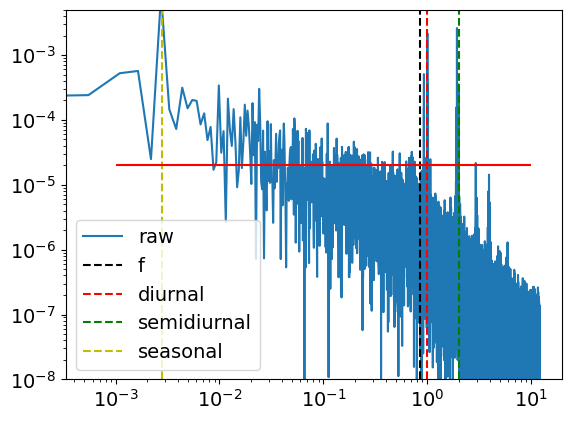

In [62]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.loglog(freq*24,ps,label='raw')

# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=28,y=12).ps,label='filtered')
# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=12,y=28).ps,label='filtered')


# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=10,y=10).ps,label='filtered')
# plt.loglog(spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).freq*24,spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).ps)
# plt.loglog(spectral_u_hann.isel(x=10,y=10).freq*24,spectral_u_hann.isel(x=10,y=10).ps,label='hann')
# plt.loglog(spectral_u.isel(x=10,y=10).freq*24,spectral_u.isel(x=10,y=10).ps,label='detrend')

ymin,ymax = 1e-8,5e-3
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.8e-3],ymin,ymax,color=['y'],linestyle='--',label='seasonal')

# plt.vlines(spectral_u.freq[test[0]+idx].data*24,ymin,ymax,color='k')
plt.legend(loc='lower left')
plt.ylim([ymin,ymax]);

plt.hlines(2e-5,1e-3,10,color='r')
plt.savefig(figure_path + '/spectrum_example.png')

## Rotary spectrum

In [5]:
spectral_rotary = spectral_analysis(velocity.u_detrended+1j*velocity.v_detrended)

spectral_rotary = spectral_rotary.where(spectral_rotary!=0)

spectral_rotary_nocomplex = spectral_rotary.copy()

spectral_rotary_nocomplex['f_k_real'] = np.real(spectral_rotary_nocomplex.f_k)
spectral_rotary_nocomplex['f_k_imag'] = np.imag(spectral_rotary_nocomplex.f_k)

spectral_rotary_nocomplex = spectral_rotary_nocomplex.drop(['f_k'])

spectral_rotary_nocomplex.to_netcdf(input_path + 'spectral_rotary.nc')

In [63]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,12,28]+1j*velocity.v_detrended[:,12,28],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,t = nufft(velocity.u_filtered[:,10,10]+1j*velocity.v_filtered[:,10,10],xarray_apply=False)

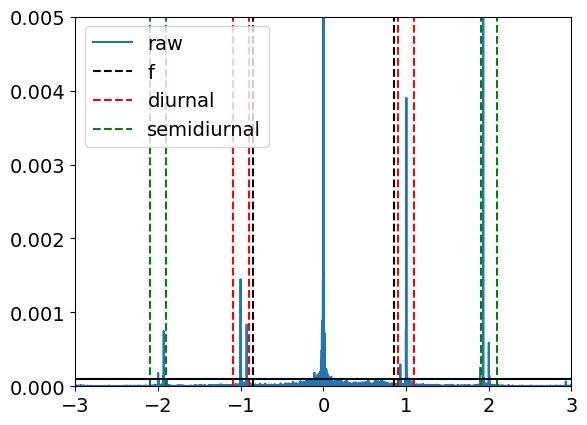

In [66]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

# plt.plot(spectral_rotary.freq*24,spectral_rotary.isel(x=10,y=10).ps,label='raw')
plt.plot(freq*24,ps,label='raw')

plt.xlim([-3,3])
ymin,ymax = 0,0.005
plt.vlines([f_coriolis,-f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
# plt.vlines([1,-1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([0.9,1.1,-0.9,-1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
# plt.vlines([-0.9,-1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')

# plt.vlines([2,-2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.1,-2.1,1.9,-1.9],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
# plt.vlines([1.9,-1.9],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')

plt.hlines(1e-4,-3,3,color='k')
plt.legend()
plt.ylim([ymin,ymax]);

plt.savefig(figure_path + 'spectrum_example_rotary.png')

## find peaks

In [5]:
# diurnal_u = find_peaks_xr(spectral_u,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
# semidiurnal_u = find_peaks_xr(spectral_u,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

diurnal_v = find_peaks_xr(spectral_v,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
semidiurnal_v = find_peaks_xr(spectral_v,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

C:\Users\2311043\AppData\Local\Temp\ipykernel_14756\1391194171.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([freq_max,peak_max])


### u

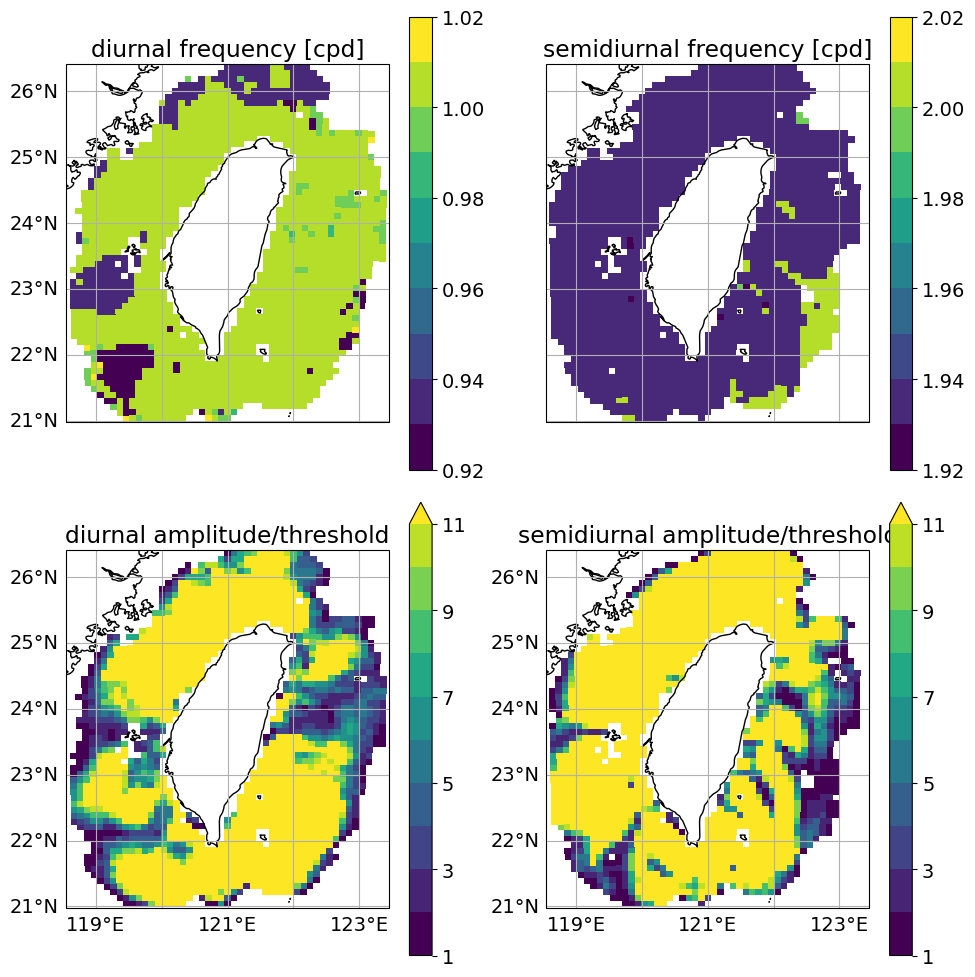

In [8]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

plt.savefig(figure_path + 'tides_u.png')

### v

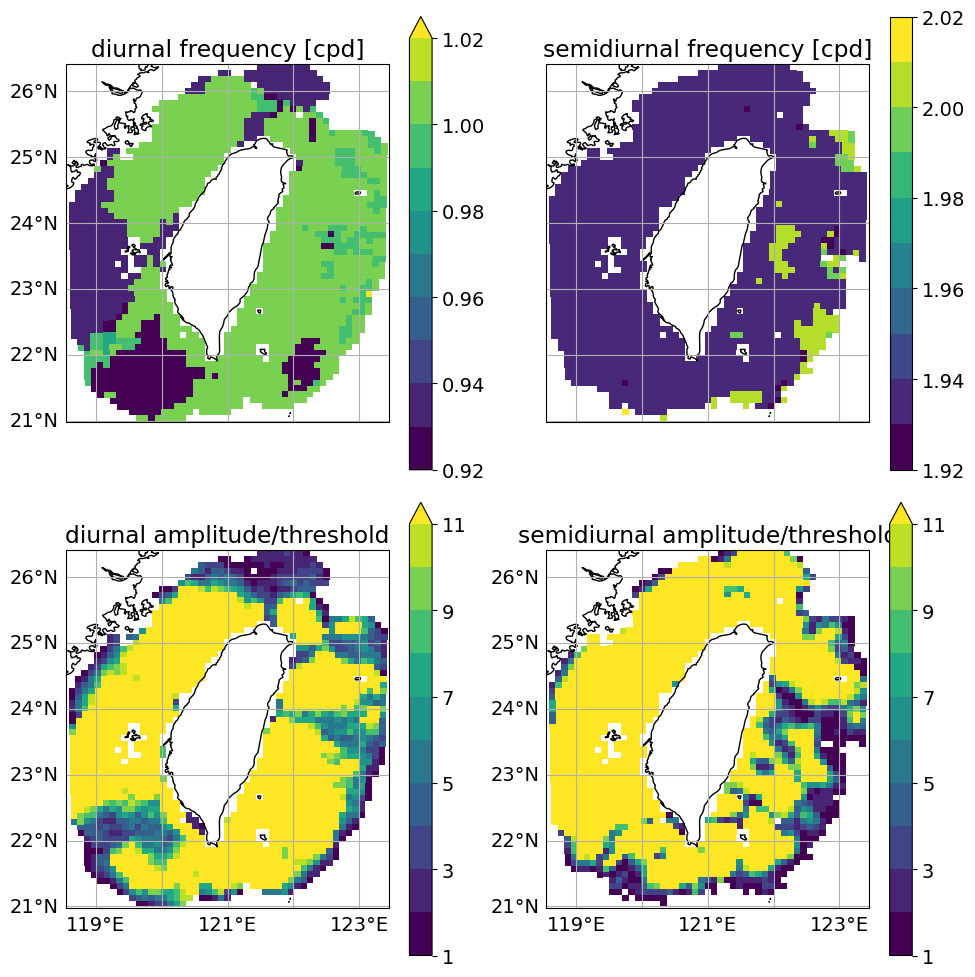

In [6]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

plt.savefig(figure_path + 'tides_v.png')

### rot

In [5]:
diurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=0.9/24,freq_max=1.1/24,peak_height=1e-4)
semidiurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=1.9/24,freq_max=2.1/24,peak_height=1e-4)

C:\Users\2311043\AppData\Local\Temp\ipykernel_1496\1449752959.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([freq_max,peak_max])


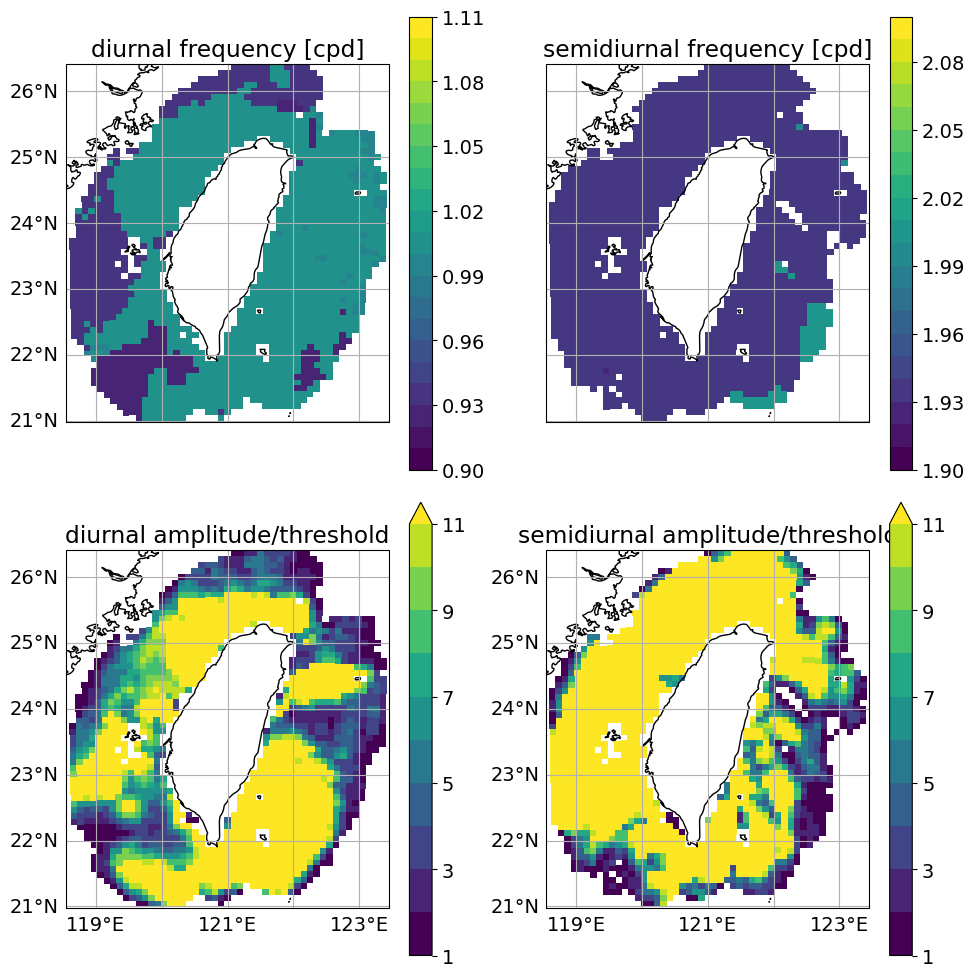

In [6]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.9,1.11,0.01))
(diurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.9,2.11,0.01))
(semidiurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

plt.savefig(figure_path + 'tides_rot.png')

# tidal ellipse

In [430]:
value,f_index = find_nearest(spectral_rotary.freq*24,1)

In [436]:
x=10;y=10
fm,fp = spectral_rotary.isel(freq=[43824-f_index[0],f_index[0]],x=x,y=y).f_k

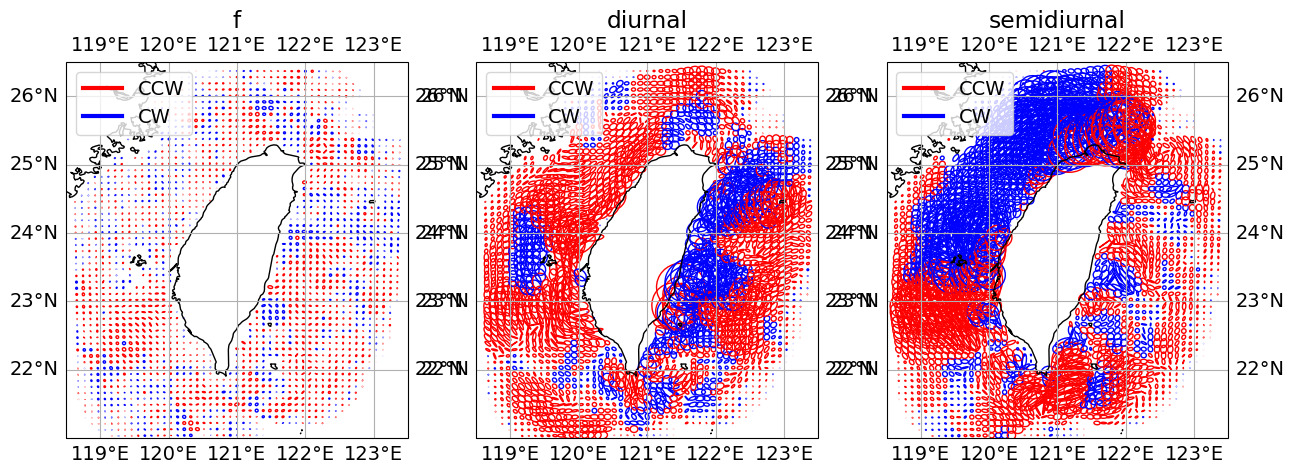

In [9]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24
colors = ['r', 'b']
lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
labels = [ 'CCW', 'CW']

fig, axs = plt.subplots(1,3,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,f,title in zip(axs.ravel(),[f_coriolis,1,2],['f','diurnal','semidiurnal']):
    value,f_index = find_nearest(spectral_rotary.freq*24,f)
    for x in range(49):
        for y in range(60):
            fm,fp = spectral_rotary.isel(freq=[43824-f_index[0],f_index[0]],x=x,y=y).f_k
            if ~np.isnan(np.abs(fm)):
                major,minor,azimuth = ellipse_details(fm,fp)
                lonlat = [fm.lon.data ,  fm.lat.data]
                rot = int(np.abs(fp).data > np.abs(fm).data)
                ell = mpl.patches.Ellipse(xy=lonlat, width=major/1e4, height=minor/1e4, angle = azimuth*180/np.pi,fc='none',ec=['b','r'][rot],transform=ccrs.PlateCarree())

                ax.add_patch(ell)
            else:
                continue
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_aspect('equal')
    ax.autoscale()
    ax.set_title(title)
    ax.legend(lines,labels,loc='upper left')
    ax.set_extent([118.5,123.5,21,26.5])
plt.savefig(figure_path + 'tidal_ellipses.png')

# time filtering

you need to add mean and trend again!

In [ ]:
# u_reconstructed_hann = filter_window(spectral_u,'hanning',T=49)
# u_reconstructed_but = filter_window(spectral_u,'butterworth',fc=1/40,order=10)

v_reconstructed_hann = filter_window(spectral_v,'hanning',T=49)
v_reconstructed_but = filter_window(spectral_v,'butterworth',fc=1/40,order=10)

In [11]:
# u_filtered_but = u_reconstructed_but + velocity.u_trend + velocity.u_mean
# u_filtered_hann = u_reconstructed_hann + velocity.u_trend + velocity.u_mean

v_filtered_but = v_reconstructed_but + velocity.v_trend + velocity.v_mean
v_filtered_hann = v_reconstructed_hann + velocity.v_trend + velocity.v_mean

In [12]:
# u_filtered_but.to_netcdf(input_path + 'u_filtered_but.nc')
# u_filtered_hann.to_netcdf(input_path + 'u_filtered_hann.nc')

v_filtered_but.to_netcdf(input_path + 'v_filtered_but.nc')
v_filtered_hann.to_netcdf(input_path + 'v_filtered_hann.nc')

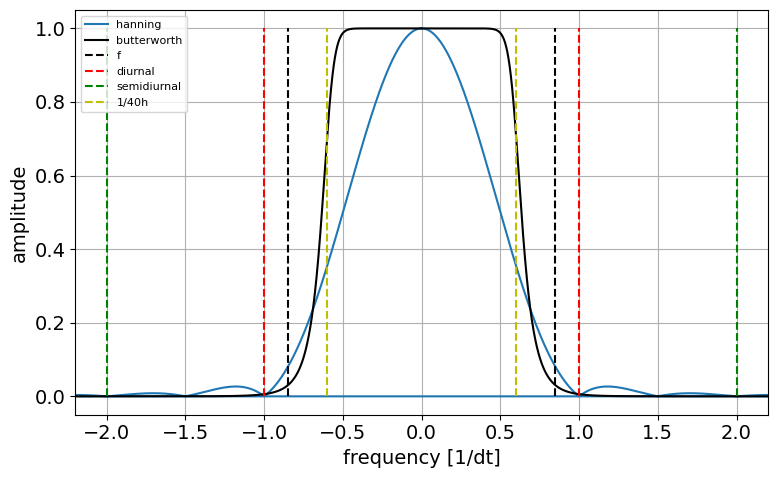

In [78]:
n = 43824

f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs = [axs]
# axs[0].plot(freq_pos*24,ps_pos/ps_pos.max(),label='power spectrum')

for k in [24]:
    T = 2 * k + 1
#     w = np.zeros(n)
#     w[n//2 - k : n//2+k+1] = np.hanning(T)
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.fftfreq(n)
    w_transform = np.fft.fft(w, n=n)
#     w_transform = np.ones_like(freq)
#     w_transform = (
#         0j 
#         + .5 * T * np.sinc(freq * T)
#         + .25 * T * np.sinc(T * (freq - 1 / T))
#         + .25 * T * np.sinc(T * (freq + 1 / T))
#     )
    w_transform /= w_transform[0]
    w_power = w_transform * w_transform.conj()

    plt.sca(axs[0])
    plt.plot(freq_hann*24, np.abs(w_transform),label='hanning')
    
    # plt.sca(axs[1])
    # plt.plot(freq, np.angle(w_transform), )

axs[0].set(ylabel='amplitude', xlabel='frequency [1/dt]')
axs[0].grid()



N_freq = 43824
k = -N_freq//2 + np.arange(N_freq)
freq = k/N_freq
fs = 1/3600
nyq = 0.5 * fs
fc = 1/(40*3600)
freqs = freq/3600

b,a = scipy.signal.butter(N=10,Wn=fc,btype='lowpass',fs = fs)
w, h = scipy.signal.freqz(b,a,fs=fs,worN=freqs)
plt.plot(w*3600*24, abs(h),color='k',label='butterworth')

ymin,ymax = 0,1
plt.vlines([-f_coriolis,f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([-1,1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([-2,2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([-24/40,24/40],ymin,ymax,color=['y'],linestyle='--',label='1/40h')

plt.legend(loc='upper left',fontsize=8)
plt.xlim([-2.2,2.2])
# axs[1].set(ylabel='phase')
# axs[1].grid()
plt.tight_layout();
plt.savefig(figure_path + 'butterworth_filter.png', bbox_inches='tight', pad_inches=.1);

C:\Users\2311043\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


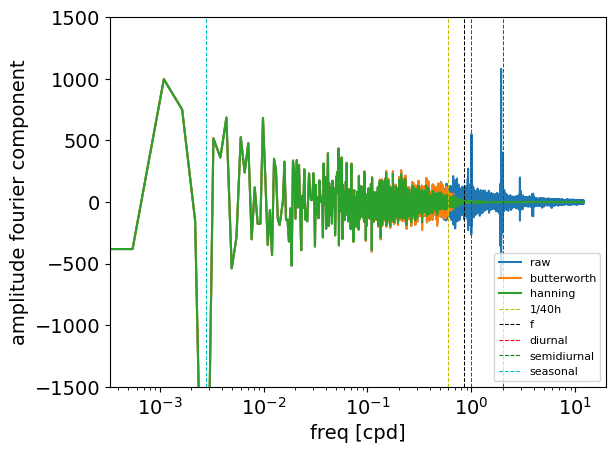

In [75]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,12,28],xarray_apply=False)
# fs = 1/3600
# nyq = 0.5 * fs
# fc = 1/(40*3600)
# freqs = freq/3600

# b,a = scipy.signal.butter(N=10,Wn=fc,btype='lowpass',fs = fs)
# w, h = scipy.signal.freqz(b,a,fs=fs,worN=freqs)

freq_but,amp_but = butterworth_window(43824,1/40,10)
freq_hann,amp_hann = hann_window(43824,49)


plt.semilogx(freq*24,f_k,label='raw')
plt.semilogx(freq*24,f_k*abs(amp_but),label='butterworth')
plt.semilogx(freq*24,f_k*abs(amp_hann),label='hanning')


ymin,ymax = -1500,1500
plt.vlines([24/40],ymin,ymax,color=['y'],linestyle='--',label='1/40h',linewidth=0.75)
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f',linewidth=0.75)
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal',linewidth=0.75)
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal',linewidth=0.75)
plt.vlines([2.8e-3],ymin,ymax,color=['c'],linestyle='--',label='seasonal',linewidth=0.75)

plt.legend(loc='lower right',fontsize=8)

plt.xlabel('freq [cpd]')
plt.ylabel('amplitude fourier component')

plt.ylim([ymin,ymax])
plt.savefig(figure_path + 'fk_filters.png')

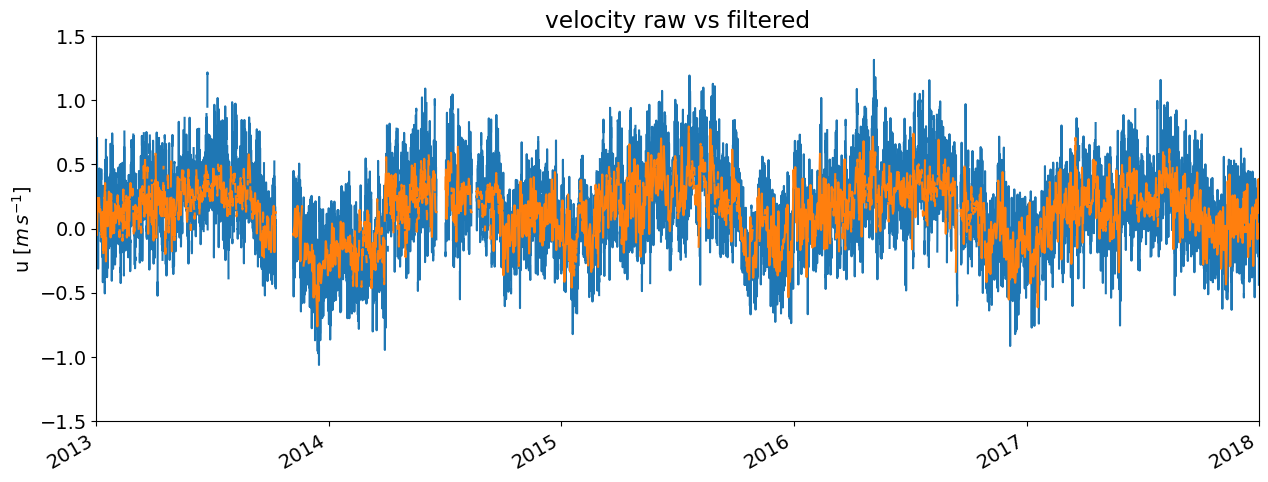

In [88]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
velocity.u[:,12,28].plot(ax=ax)
velocity.u_filtered[:,12,28].plot(ax=ax)
ax.set_title('velocity raw vs filtered')
ax.set_xlabel(''),ax.set_ylabel('u $[m\,s^{-1}]$')
ax.set_ylim([-1.5,1.5]),ax.set_xlim([datetime(2013,1,1),datetime(2018,1,1)])
plt.savefig(figure_path + 'raw_vs_filtered_example.png')

# Section Extraction

In [62]:
north_section_ = section_indices(velocity,(26,120),(25,121))
mid_section_ = section_indices(velocity,(24.65,118.75),(24,120.25))
south_section_ = section_indices(velocity,(23.1,118.5),(23.1,120))

In [ ]:
north_section = extract_section(velocity,(26,120),(25,121))
mid_section = extract_section(velocity,(24.65,118.75),(24,120.25))
south_section = extract_section(velocity,(23.1,118.5),(23.1,120))

Text(0.5, 1.0, 'sections in Taiwan Strait')

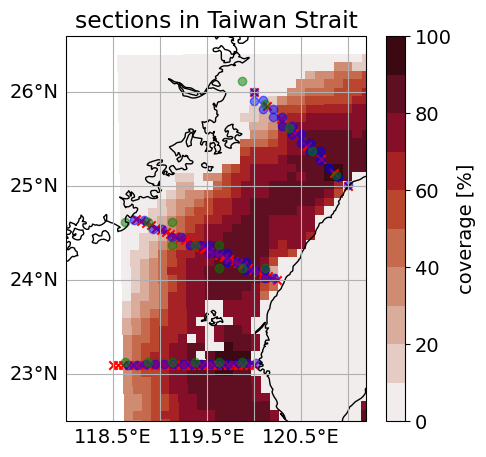

In [56]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1,x='lon',y='lat',levels=np.arange(0,110,10),cmap=cmo.amp,cbar_kwargs={'label':'coverage [%]'})

ax1.set_extent([118,121.2,22.5,26.6])
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

plt.scatter(north_section_[3],north_section_[2],color='r',marker='x')
plt.scatter(mid_section_[3],mid_section_[2],color='r',marker='x')
plt.scatter(south_section_[3],south_section_[2],color='r',marker='x')



xr.plot.scatter(ds=north_section,x='lon',y='lat',color='b',alpha=0.5)
xr.plot.scatter(ds=mid_section,x='lon',y='lat',color='b',alpha=0.5)
xr.plot.scatter(ds=south_section,x='lon',y='lat',color='b',alpha=0.5)
xr.plot.scatter(ds=north_section_ssh,x='lon',y='lat',color='g',alpha=0.5)
xr.plot.scatter(ds=mid_section_ssh,x='lon',y='lat',color='g',alpha=0.5)
xr.plot.scatter(ds=south_section_ssh,x='lon',y='lat',color='g',alpha=0.5)

ax1.set_title('sections in Taiwan Strait')
# plt.savefig(figure_path + 'sections_map.png')

# rotate velocities

In [103]:
north_section = rotate_section(north_section,['u_filtered','v_filtered'])
mid_section = rotate_section(mid_section,['u_filtered','v_filtered'])
south_section = rotate_section(south_section,['u_filtered','v_filtered'])

In [104]:
north_mean = north_section.mean(dim='time')

north_u_std = north_section.along_vel.std(dim='time')
north_v_std = north_section.cross_vel.std(dim='time')

mid_mean = mid_section.mean(dim='time')

mid_u_std = mid_section.along_vel.std(dim='time')
mid_v_std = mid_section.cross_vel.std(dim='time')

south_mean = south_section.mean(dim='time')

south_u_std = south_section.along_vel.std(dim='time')
south_v_std = south_section.cross_vel.std(dim='time')

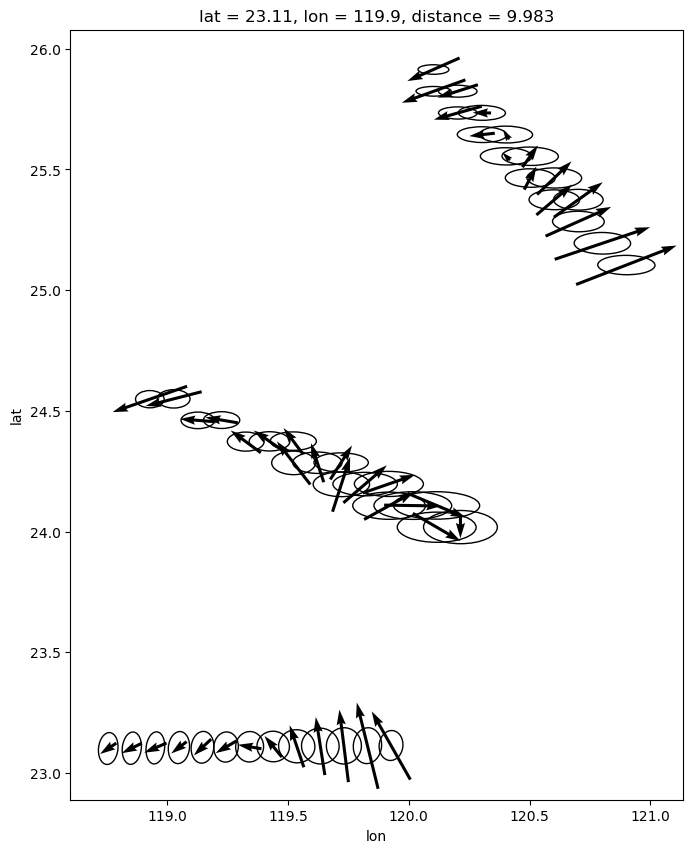

In [105]:
fig,ax= plt.subplots(1,1,figsize=(10,10))
for s in np.arange(2,len(north_mean.s)-1):
    north_mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=1,linewidth=0.5,width=0.005,add_guide=False)
    ell = mpl.patches.Ellipse(xy=[north_section.isel(s=s).lon,north_section.isel(s=s).lat],
                              width=north_u_std.isel(s=s), height=north_v_std.isel(s=s), 
                              angle = -np.deg2rad(calculate_initial_compass_bearing(
                                  (north_section.lon[0],north_section.lat[0]),(north_section.lon[-1],north_section.lat[-1]))),fc='none',ec='k')
    ax.add_patch(ell)
    
for s in np.arange(2,len(mid_mean.s)):
    mid_mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=1,linewidth=0.5,width=0.005,add_guide=False)
    ell = mpl.patches.Ellipse(xy=[mid_section.isel(s=s).lon,mid_section.isel(s=s).lat],
                              width=mid_u_std.isel(s=s), height=mid_v_std.isel(s=s), 
                              angle = -np.deg2rad(calculate_initial_compass_bearing(
                                  (mid_section.lon[0],mid_section.lat[0]),(mid_section.lon[-1],mid_section.lat[-1]))),fc='none',ec='k')
    ax.add_patch(ell)
    
for s in np.arange(1,len(south_mean.s)-1):
    south_mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=1,linewidth=0.5,width=0.005,add_guide=False)
    ell = mpl.patches.Ellipse(xy=[south_section.isel(s=s).lon,south_section.isel(s=s).lat],
                              width=south_u_std.isel(s=s), height=south_v_std.isel(s=s), 
                              angle = -np.deg2rad(calculate_initial_compass_bearing(
                                  (south_section.lon[0],south_section.lat[0]),(south_section.lon[-1],south_section.lat[-1]))),fc='none',ec='k')
    ax.add_patch(ell)
    ax.set_aspect('equal')
    ax.autoscale()

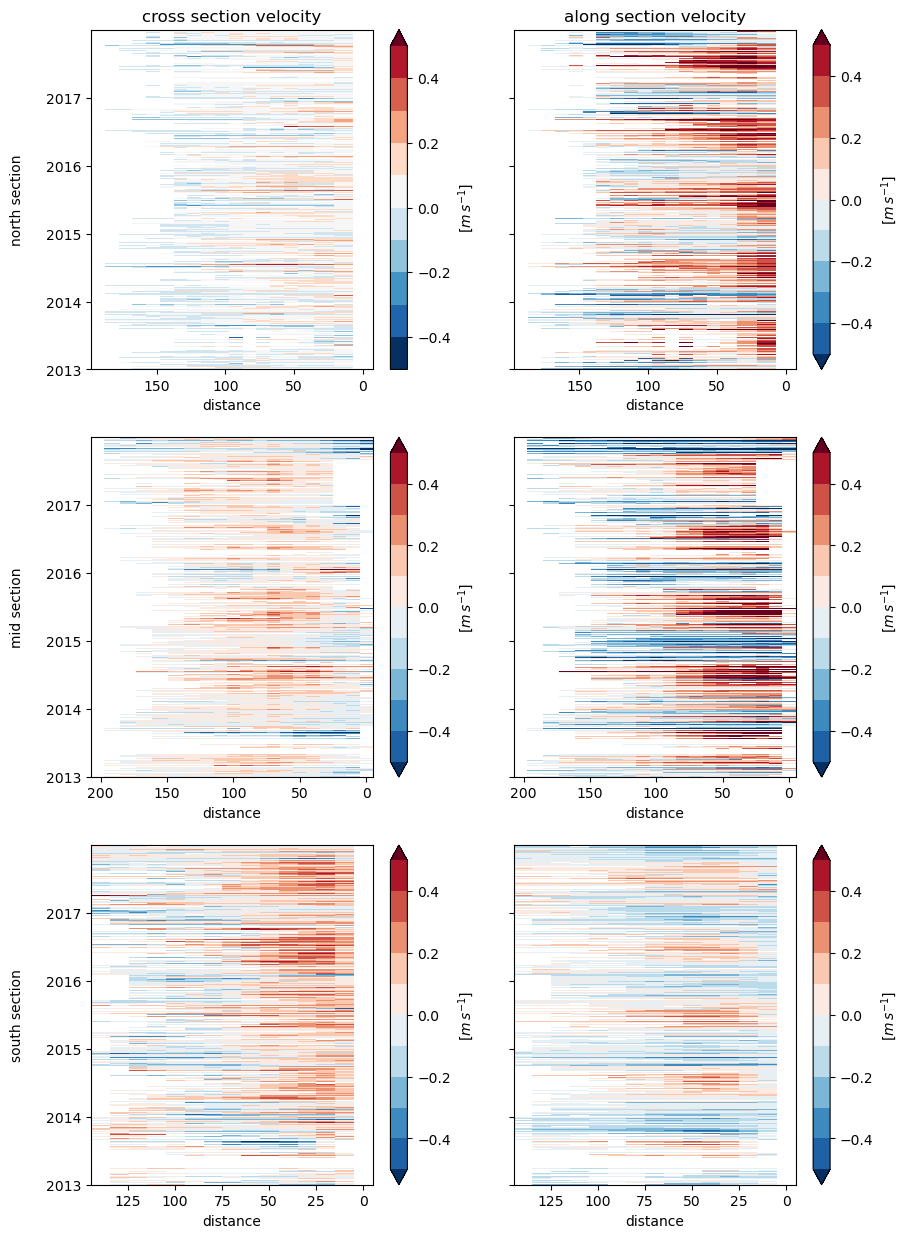

In [106]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharey=True,figsize=(10,15))

north_section.cross_vel.plot(ax=ax1,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
north_section.along_vel.plot(ax=ax2,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

mid_section.cross_vel.plot(ax=ax3,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
mid_section.along_vel.plot(ax=ax4,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

south_section.cross_vel.plot(ax=ax5,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
south_section.along_vel.plot(ax=ax6,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

ax1.set_ylabel('north section\n'),ax2.set_ylabel(''),ax3.set_ylabel('mid section\n'),ax4.set_ylabel(''),ax5.set_ylabel('south section\n'),ax6.set_ylabel('')
ax1.set_title('cross section velocity'),ax2.set_title('along section velocity');

# plt.savefig(figure_path + 'sections_hovmoeller.png')

(15706.0, 17532.0)

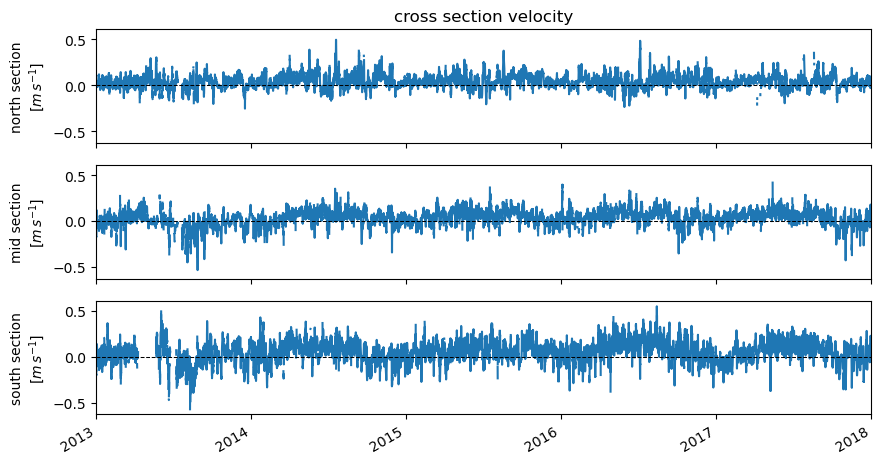

In [107]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,5))
north_section.mean(dim='s').cross_vel.plot(ax=ax1,label='north')
mid_section.mean(dim='s').cross_vel.plot(ax=ax2,label='mid')
south_section.mean(dim='s').cross_vel.plot(ax=ax3,label='south')
ax1.set_xlabel(''),ax2.set_xlabel(''),ax3.set_xlabel('')
ax1.set_ylabel('north section\n' + '$[m\,s^{-1}]$'),ax2.set_ylabel('mid section\n' + '$[m\,s^{-1}]$'),ax3.set_ylabel('south section\n' + '$[m\,s^{-1}]$')
ax1.set_title('cross section velocity')

xmin,xmax = datetime(2013,1,1),datetime(2018,1,1)
ax1.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax2.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax3.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax1.set_xlim([xmin,xmax])

# plt.savefig(figure_path + 'sections_mean_timeseries.png')

(15706.0, 17532.0)

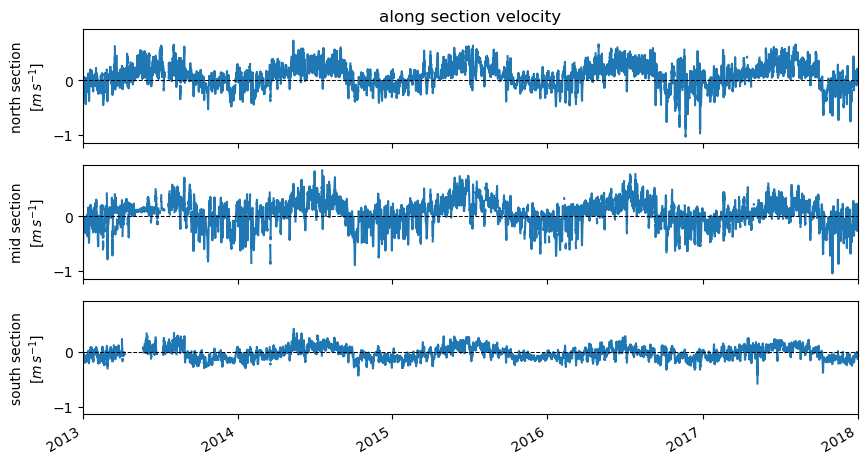

In [114]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,5))
north_section.mean(dim='s').along_vel.plot(ax=ax1,label='north')
mid_section.mean(dim='s').along_vel.plot(ax=ax2,label='mid')
south_section.mean(dim='s').along_vel.plot(ax=ax3,label='south')
ax1.set_xlabel(''),ax2.set_xlabel(''),ax3.set_xlabel('')
ax1.set_ylabel('north section\n' + '$[m\,s^{-1}]$'),ax2.set_ylabel('mid section\n' + '$[m\,s^{-1}]$'),ax3.set_ylabel('south section\n' + '$[m\,s^{-1}]$')
ax1.set_title('along section velocity')

xmin,xmax = datetime(2013,1,1),datetime(2018,1,1)
ax1.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax2.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax3.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax1.set_xlim([xmin,xmax])

# plt.savefig(figure_path + 'sections_mean_timeseries.png')

In [34]:
velocity_masked = velocity.where(velocity.coverage>0.5)

In [83]:
# mean = velocity.mean(dim='time')
# std = velocity.std(dim='time')

velocity['coverage'] = velocity.coverage.where(velocity.coverage!=0)

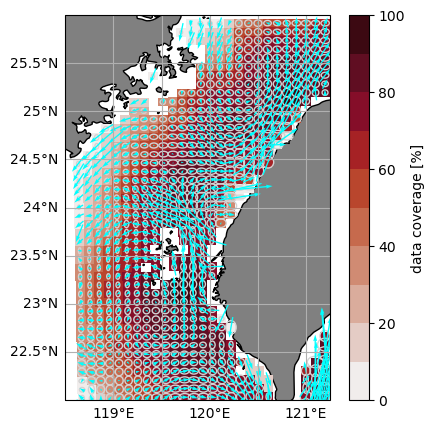

In [115]:
fig, ax = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.isel(x=slice(0,27),y=slice(0,55)).coverage*100).plot(x='lon',y='lat',cmap=cmo.amp,levels=np.arange(0,110,10),cbar_kwargs={'ticks':np.arange(0,120,20),'label':'data coverage [%]'})

for x in np.arange(0,27):
    for y in np.arange(0,55):
        if ~np.isnan(std.isel(x=x,y=y).u_filtered):
            ell = mpl.patches.Ellipse(xy=[std.isel(x=x,y=y).lon,std.isel(x=x,y=y).lat], 
                                      width=std.isel(x=x,y=y).u_filtered/2, height=std.isel(x=x,y=y).v_filtered/2, angle = 0,fc='none',ec='lightgrey',transform=ccrs.PlateCarree())

            ax.add_patch(ell)
        else:
            continue
            
# xr.plot.scatter(ax=ax,ds=velocity.isel(x=26,y=20),x='lon',y='lat',transform=ccrs.PlateCarree())
mean.isel(x=slice(0,27),y=slice(0,55)).plot.quiver(ax=ax,x='lon',y='lat',u='u_filtered',v='v_filtered',linewidth=0.5,width=0.005,scale=2,color='cyan',add_guide=False)
# ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')

gl = ax.gridlines(draw_labels=True)
ax.set_aspect('equal')
ax.autoscale()
ax.set_extent([118.5,121.25,22,26])
gl.right_labels=False
gl.top_labels=False

# plt.savefig(figure_path + 'taiwanstrait_mean_std_coverage.png')

# Wind

In [23]:
wind = xr.open_dataset(input_path + 'ERA5_10m_winds.nc')
wind = wind.rename({'longitude':'lon','latitude':'lat'})
# velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_ERA5Grid.nc')

In [96]:
wind = (wind*~np.isnan(velocity.u_filtered))
wind = wind.where(wind.u10!=0)

In [97]:
wind['abs'] = np.sqrt(wind.u10**2 + wind.v10**2)

In [98]:
c_D = 0.0015
rho_air = 1.2
wind['taux'] = rho_air * c_D * wind.abs * wind.u10
wind['tauy'] = rho_air * c_D * wind.abs * wind.v10

In [99]:
wind_vel = xr.merge([wind,velocity])

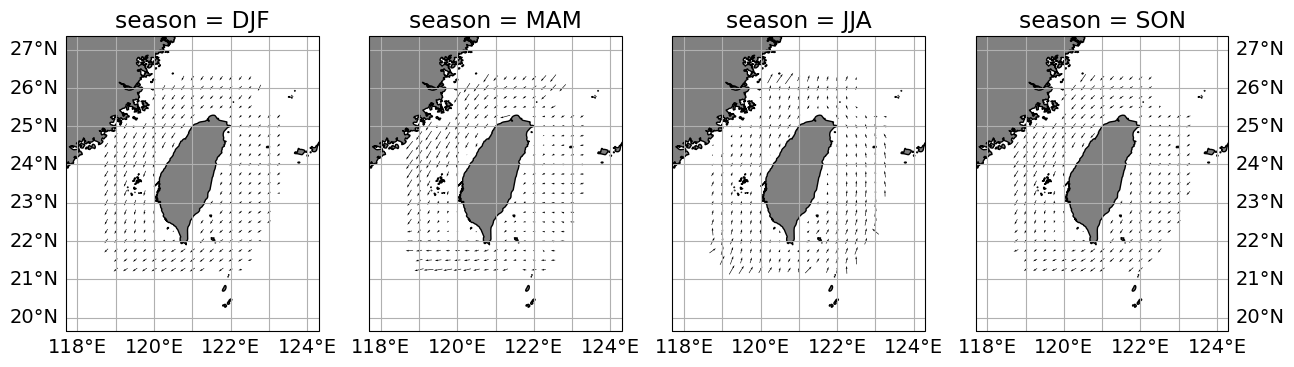

In [100]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

season_mean = wind.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','u10','v10',ax=ax1,add_guide=False)
season_mean.sel(season='MAM').plot.quiver('lon','lat','u10','v10',ax=ax2,add_guide=False)
season_mean.sel(season='JJA').plot.quiver('lon','lat','u10','v10',ax=ax3,add_guide=False)
season_mean.sel(season='SON').plot.quiver('lon','lat','u10','v10',ax=ax4,add_guide=False)

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
gl2.left_labels=False

ax3.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels=False
gl3.right_labels=False
gl3.left_labels=False

ax4.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels=False
gl4.left_labels=False

plt.savefig(figure_path + 'winds_seasonal.png')

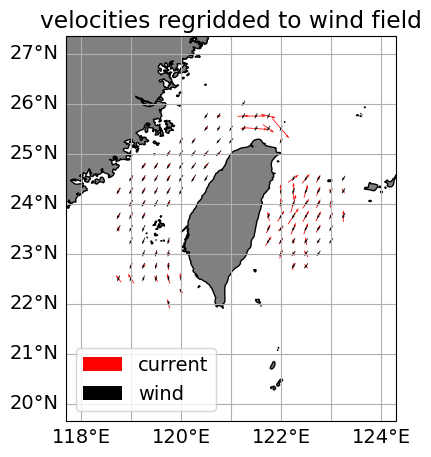

In [106]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})
velocity.isel(time=200).plot.quiver(x='lon',y='lat',u='u_filtered',v='v_filtered',color='r',add_guide=False,label='current')
(wind*~np.isnan(velocity.u_filtered)).isel(time=200).plot.quiver(x='lon',y='lat',u='u10',v='v10',add_guide=False,label='wind')
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False
ax1.legend(loc='lower left')
ax1.set_title('velocities regridded to wind field')
plt.savefig(figure_path + 'velocity_wind_grid.png',dpi=300)

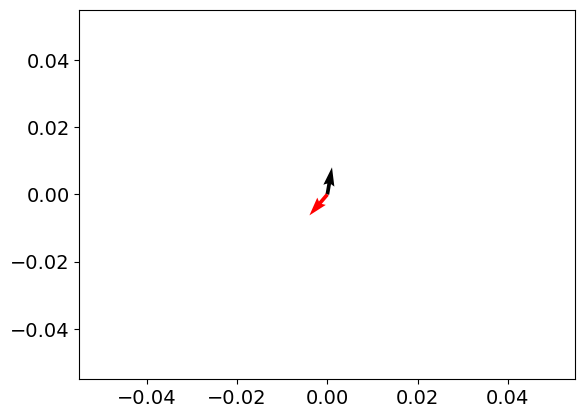

In [ ]:
# plt.quiver(0,0,velocity.u_filtered[1,12,20],velocity.v_filtered[1,12,20])
plt.quiver(0,0,velocity.u[-1,12,20],velocity.v[-1,12,20])

plt.quiver(0,0,wind.taux[-1,12,20],wind.tauy[-1,12,20],color='r')

In [91]:
# v1 = [velocity.u_filtered[200,12,20],velocity.v_filtered[200,12,20]]
v1 = [(u,v) for u,v in zip(velocity.u[:,12,20].data,velocity.v[:,12,20].data)]

v2 = [(u,v) for u,v in zip(wind.taux[:,12,20].data,wind.tauy[:,12,20].data)]

np.degrees(list(map(angle_between,v1,v2)))

array([         nan,  92.43199868,  96.51287454, ..., 149.83431261,
       147.81528909, 149.1096531 ])

In [ ]:
angles = angle_between_vectors_xarray(wind_vel,['u','v','taux','tauy'])

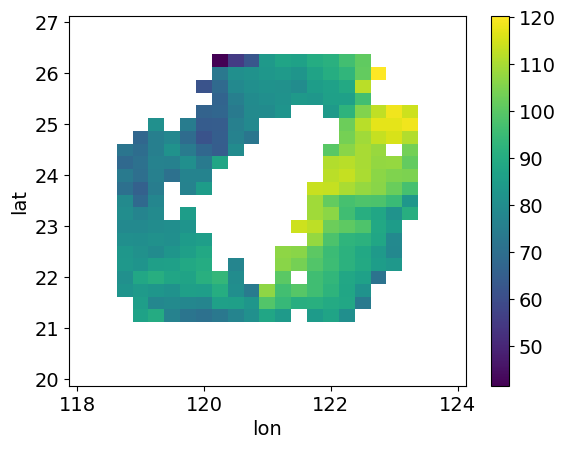

In [57]:
np.degrees(angles.mean(dim='time')).plot()

# EOF

In [3]:
# from eofs.standard import Eof

# test = velocity.fillna(0).u_filtered + 1j*velocity.fillna(0).v_filtered

u4eof = velocity.u_filtered - velocity.u_filtered.mean(dim='time')
v4eof = velocity.v_filtered - velocity.v_filtered.mean(dim='time')

In [14]:
coslat = np.cos(np.deg2rad(velocity.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[np.newaxis,...]

In [28]:
usolver = Eof(u4eof.fillna(0).data, weights=wgts)

vsolver = Eof(v4eof.fillna(0).data, weights=wgts)

In [54]:
ueof = usolver.eofs()
veof = vsolver.eofs()

In [57]:
velocity['ueof1'] = (['y','x'],np.squeeze(ueof[0,:,:]))
velocity['veof1'] = (['y','x'],np.squeeze(veof[0,:,:]))

In [59]:
velocity['ueof2'] = (['y','x'],np.squeeze(ueof[1,:,:]))
velocity['veof2'] = (['y','x'],np.squeeze(veof[1,:,:]))

In [60]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
velocity.plot.quiver(ax=ax1,x='lon',y='lat',u='ueof1',v='veof1')

velocity.plot.quiver(ax=ax2,x='lon',y='lat',u='ueof2',v='veof2')



In [62]:
vsolver.varianceFraction()

array([1.71354212e-01, 9.46681380e-02, 6.37771235e-02, ...,
       7.37247878e-35, 6.93630317e-35, 6.26688965e-36])

In [61]:
upcs = usolver.pcs()
vpcs = vsolver.pcs()

In [5]:
data1,data2 = u4eof.fillna(0).data,v4eof.fillna(0).data

In [12]:
import eofs.multivariate as meofs


In [ ]:
mvsolver = meofs.standard.MultivariateEof([data1,data2],weights=[wgts,wgts])


# SSH

In [136]:
ssh = xr.open_dataset(input_path + 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1679615605995.nc')
ssh = ssh.rename({'latitude':'lat','longitude':'lon'})
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_CMEMSGrid.nc')
velocity = velocity.resample(time='1D').mean()

In [34]:
wind = wind.resample(time='1D').mean()

In [137]:
ssh = (ssh*~np.isnan(velocity.u_filtered))
ssh = ssh.where(ssh.ugos!=0)

In [146]:
ssh['abs'] = np.sqrt(ssh.ugos**2 + ssh.vgos**2)
velocity['abs'] = np.sqrt(velocity.u_filtered**2 + velocity.v_filtered**2)

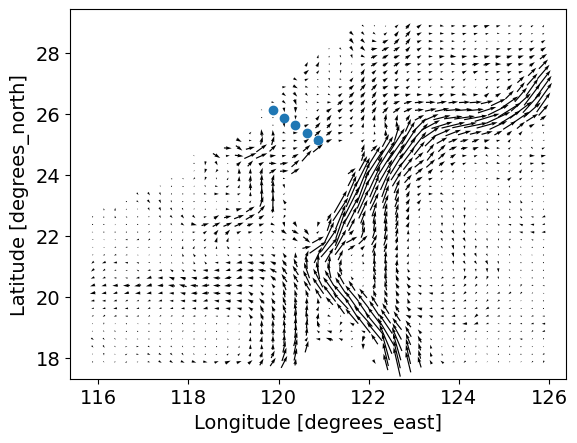

In [50]:
ssh.mean(dim='time').plot.quiver(x='lon',y='lat',u='ugos',v='vgos')
xr.plot.scatter(north_section_ssh,x='lon',y='lat')

In [151]:
north_section_ssh = extract_section(ssh,(26,120),(25,121))
mid_section_ssh = extract_section(ssh,(24.65,118.75),(24,120.25))
south_section_ssh = extract_section(ssh,(23.1,118.5),(23.1,120))

north_section_ssh = rotate_section(north_section_ssh,['ugos','vgos'])
mid_section_ssh = rotate_section(mid_section_ssh,['ugos','vgos'])
south_section_ssh = rotate_section(south_section_ssh,['ugos','vgos'])

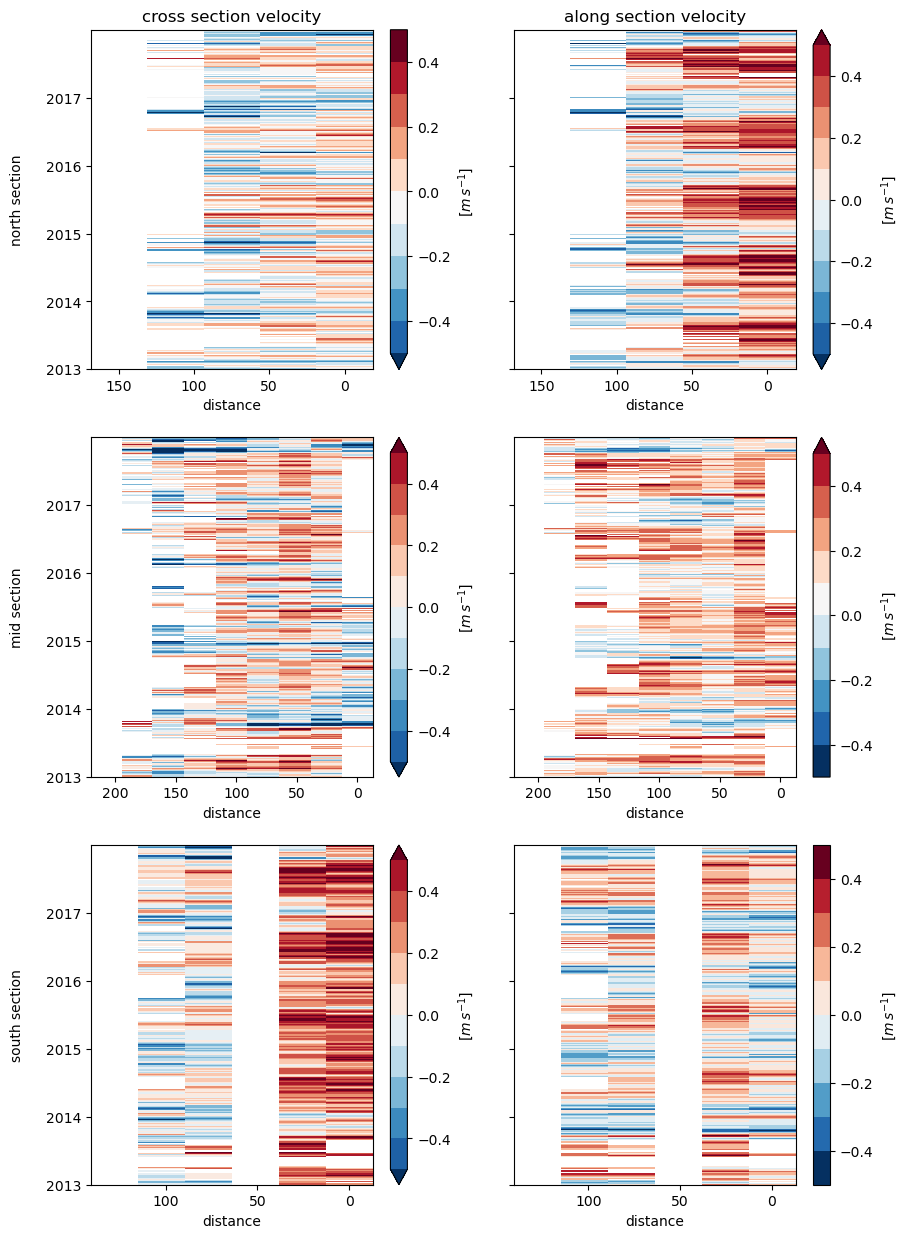

In [152]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharey=True,figsize=(10,15))

north_section_ssh.cross_vel.plot(ax=ax1,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
north_section_ssh.along_vel.plot(ax=ax2,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

mid_section_ssh.cross_vel.plot(ax=ax3,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
mid_section_ssh.along_vel.plot(ax=ax4,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

south_section_ssh.cross_vel.plot(ax=ax5,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
south_section_ssh.along_vel.plot(ax=ax6,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

ax1.set_ylabel('north section\n'),ax2.set_ylabel(''),ax3.set_ylabel('mid section\n'),ax4.set_ylabel(''),ax5.set_ylabel('south section\n'),ax6.set_ylabel('')
ax1.set_title('cross section velocity'),ax2.set_title('along section velocity');

# plt.savefig(figure_path + 'sections_hovmoeller.png')

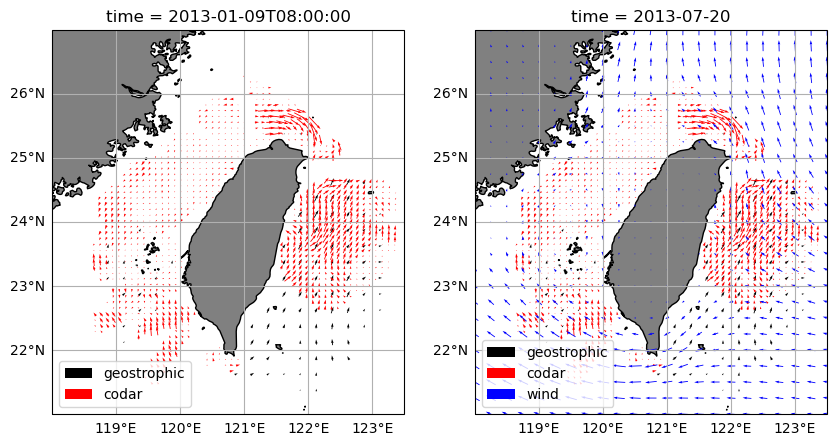

In [135]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
ssh.isel(time=200).plot.quiver(ax=ax1,x='lon',y='lat',u='ugos',v='vgos',add_guide=False,label='geostrophic')
velocity.isel(time=200).plot.quiver(ax=ax1,x='lon',y='lat',u='u_filtered',v='v_filtered',color='r',add_guide=False,label='codar')
# wind.isel(time=200).plot.quiver(ax=ax1,x='lon',y='lat',u='u10',v='v10',add_guide=False,label='wind',color='b')

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False
ax1.legend(loc='lower left')
# ax1.set_title('velocities regridded to wind field')
ax1.set_extent([118,123.5,21,27])

ssh.isel(time=200).plot.quiver(ax=ax2,x='lon',y='lat',u='ugos',v='vgos',add_guide=False,label='geostrophic')
velocity.isel(time=200).plot.quiver(ax=ax2,x='lon',y='lat',u='u_filtered',v='v_filtered',color='r',add_guide=False,label='codar')
wind.isel(time=200).plot.quiver(ax=ax2,x='lon',y='lat',u='u10',v='v10',add_guide=False,label='wind',color='b')

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
ax2.legend(loc='lower left')
# ax2.set_title('velocities regridded to wind field')
ax2.set_extent([118,123.5,21,27])


# plt.savefig(figure_path + 'velocity_ssh_grid.png',dpi=300)

In [143]:
u_diff = ssh.ugos - velocity.u_filtered
v_diff = ssh.vgos - velocity.v_filtered 

In [144]:
velocity['u_diff_mean'] = u_diff.mean(dim='time')
velocity['v_diff_mean'] = v_diff.mean(dim='time')

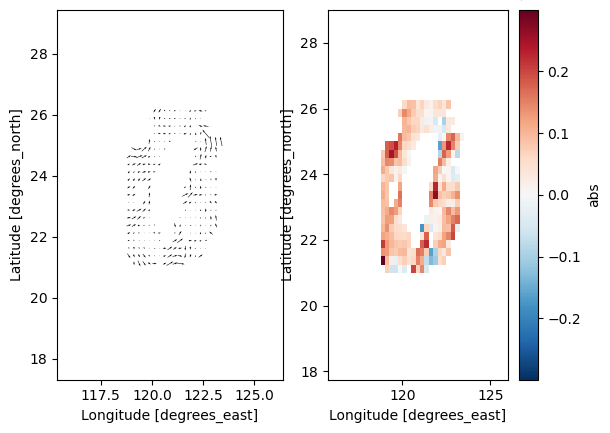

In [150]:
fig,(ax1,ax2) = plt.subplots(1,2)
velocity.plot.quiver(ax=ax1,x='lon',y='lat',u='u_diff_mean',v='v_diff_mean')
(ssh.abs - velocity.abs).mean(dim='time').plot(ax=ax2,x='lon',y='lat')

# Codar,Wind,Geostrophic Spectra

In [12]:
ssh = xr.open_dataset(input_path + 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1679615605995.nc')
ssh = ssh.rename({'latitude':'lat','longitude':'lon'})
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_CMEMSGrid.nc')
velocity = velocity.resample(time='1D').mean()
wind = xr.open_dataset(input_path + 'ERA5_10m_wind_CMEMSGrid.nc')
# wind = wind.rename({'longitude':'lon','latitude':'lat'})
wind = wind.resample(time='1D').mean()

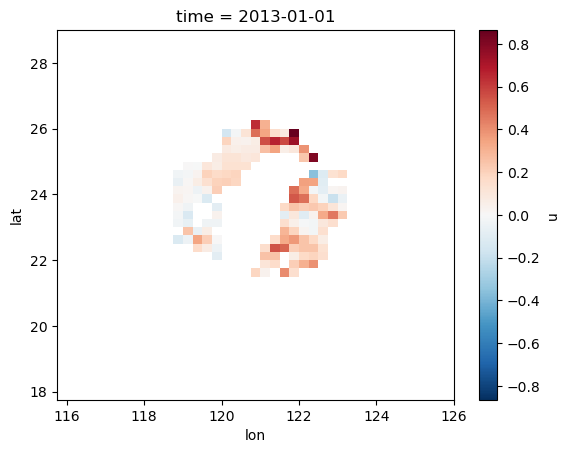

In [76]:
velocity.u[0,:,:].plot()

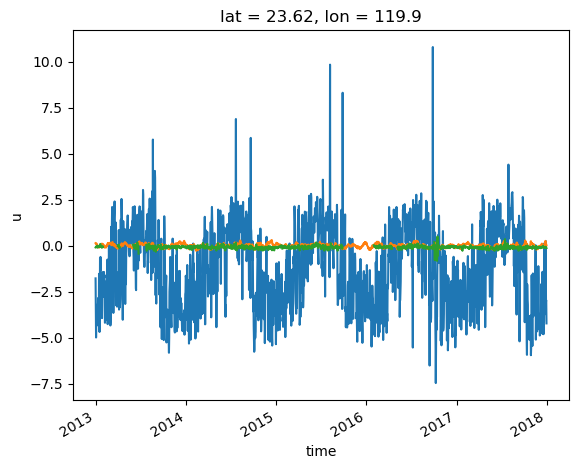

In [19]:
lat = 23.625
lon = 119.875

wind.sel(lat=lat,lon=lon).u10.plot()
ssh.sel(lat=lat,lon=lon).ugos.plot()
velocity.sel(lat=lat,lon=lon).u.plot()

In [24]:
velocity['u_demeaned'],velocity['u_mean'] = demean_xarray(velocity.u,dim='time')
velocity['v_demeaned'],velocity['v_mean'] = demean_xarray(velocity.v,dim='time')

velocity['u_detrended'],velocity['u_trend'] = detrend_xarray(velocity['u_demeaned'])
velocity['v_detrended'],velocity['v_trend'] = detrend_xarray(velocity['v_demeaned'])

In [25]:
ssh['u_demeaned'],ssh['u_mean'] = demean_xarray(ssh.ugos,dim='time')
ssh['v_demeaned'],ssh['v_mean'] = demean_xarray(ssh.vgos,dim='time')

ssh['u_detrended'],ssh['u_trend'] = detrend_xarray(ssh['u_demeaned'])
ssh['v_detrended'],ssh['v_trend'] = detrend_xarray(ssh['v_demeaned'])

In [26]:
wind['u_demeaned'],wind['u_mean'] = demean_xarray(wind.u10,dim='time')
wind['v_demeaned'],wind['v_mean'] = demean_xarray(wind.v10,dim='time')

wind['u_detrended'],wind['u_trend'] = detrend_xarray(wind['u_demeaned'])
wind['v_detrended'],wind['v_trend'] = detrend_xarray(wind['v_demeaned'])

In [27]:
freq_vel,f_k_vel,ps_vel,psd_vel,t_vel = nufft(velocity.sel(lat=lat,lon=lon).u_detrended.data + 1j*velocity.sel(lat=lat,lon=lon).v_detrended.data,xarray_apply=False)
freq_ssh,f_k_ssh,ps_ssh,psd_ssh,t_ssh = nufft(ssh.sel(lat=lat,lon=lon).u_detrended.data + 1j*ssh.sel(lat=lat,lon=lon).v_detrended.data,xarray_apply=False)
freq_wind,f_k_wind,ps_wind,psd_wind,t_wind = nufft(wind.sel(lat=lat,lon=lon).u_detrended.data + 1j*wind.sel(lat=lat,lon=lon).v_detrended.data,xarray_apply=False)

In [59]:
%run Code_functions.ipynb

spectral_vel = spectral_analysis(velocity.u_detrended + 1j*velocity.v_detrended)
spectral_ssh = spectral_analysis(ssh.u_detrended + 1j*ssh.v_detrended)
spectral_wind = spectral_analysis(wind.u_detrended + 1j*wind.v_detrended)

In [108]:
spectral_vel = spectral_vel.where(spectral_vel.ps!=0)
spectral_ssh = spectral_ssh.where(spectral_ssh.ps!=0)
spectral_wind = spectral_wind.where(spectral_wind.ps!=0)

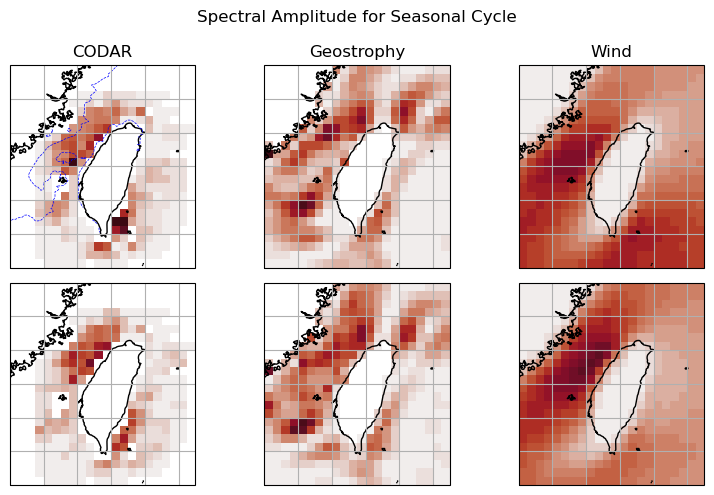

In [141]:
frequency = 1/365
levels = np.arange(0,0.021,0.001)

fig,axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(8,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

(abs(spectral_vel.ps.sel(freq=frequency,method='nearest'))).plot(ax=axs[0],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_vel.ps.sel(freq=-frequency,method='nearest'))).plot(ax=axs[3],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_ssh.ps.sel(freq=frequency,method='nearest'))).plot(ax=axs[1],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_ssh.ps.sel(freq=-frequency,method='nearest'))).plot(ax=axs[4],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_wind.ps.sel(freq=frequency,method='nearest'))/1000).plot(ax=axs[2],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_wind.ps.sel(freq=-frequency,method='nearest'))/1000).plot(ax=axs[5],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)

bathy.ROSE.plot.contour(ax=axs[0],x='lon',y='lat',levels=[-50],colors='b',linewidths=0.5)

for ax in axs:
    ax.set_title(''),ax.set_xlabel(''),ax.set_ylabel('')
    ax.coastlines()
    ax.gridlines()
    ax.set_extent([118,123.5,21,27])

axs[0].set_title('CODAR')
axs[1].set_title('Geostrophy')
axs[2].set_title('Wind')
axs[0].set_ylabel('u-component')
axs[3].set_ylabel('v-component')

fig.suptitle('Spectral Amplitude for Seasonal Cycle')
fig.tight_layout()

Text(0.5, 0, 'cpy')

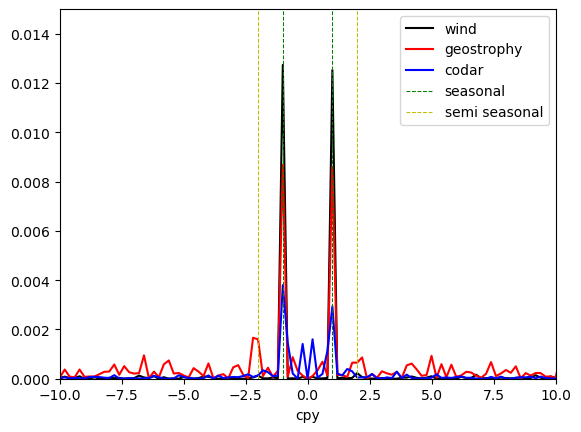

In [28]:
fig,ax1 = plt.subplots(1,1)
# ax2=ax1.twinx()
ax1.plot(freq_wind*365,ps_wind/1000,color='k',label='wind')
ax1.plot(freq_ssh*365,ps_ssh,color='r',label='geostrophy')
ax1.plot(freq_vel*365,ps_vel,color='b',label='codar')


plt.xlim([-10,10])
ax1.vlines([-1,1],0,0.015,color='g',linestyle='--',linewidth=0.75,label='seasonal')
ax1.vlines([-2,2],0,0.015,color='y',linestyle='--',linewidth=0.75,label='semi seasonal')

ax1.legend(loc='upper right')
# ax2.legend(loc='center right')
ax1.set_ylim([0,0.015])
# ax2.set_ylim([0,15])
ax1.set_xlabel('cpy')#,ax1.set_ylabel('ocean'),ax2.set_ylabel('atmosphere')

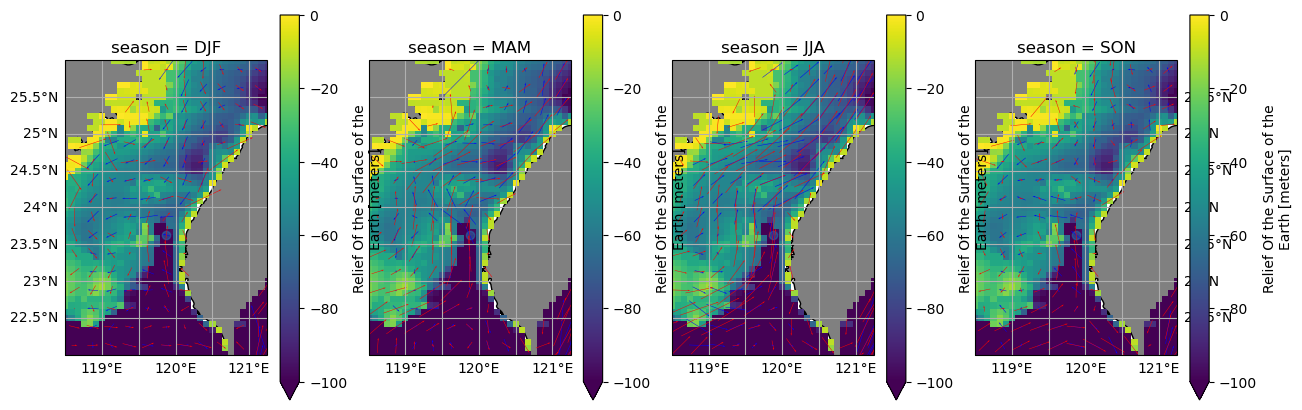

In [29]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax1,vmin=-100)
bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax2,vmin=-100)
bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax3,vmin=-100)
bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax4,vmin=-100)

ax1.scatter(lon,lat,alpha=0.5)
ax2.scatter(lon,lat,alpha=0.5)
ax3.scatter(lon,lat,alpha=0.5)
ax4.scatter(lon,lat,alpha=0.5)

season_mean = velocity.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','u','v',ax=ax1,add_guide=False,color='b',scale=2)
season_mean.sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax2,add_guide=False,color='b',scale=2)
season_mean.sel(season='JJA').plot.quiver('lon','lat','u','v',ax=ax3,add_guide=False,color='b',scale=2)
season_mean.sel(season='SON').plot.quiver('lon','lat','u','v',ax=ax4,add_guide=False,color='b',scale=2)

season_mean = ssh.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','ugos','vgos',ax=ax1,add_guide=False,color='r',scale=2)
season_mean.sel(season='MAM').plot.quiver('lon','lat','ugos','vgos',ax=ax2,add_guide=False,color='r',scale=2)
season_mean.sel(season='JJA').plot.quiver('lon','lat','ugos','vgos',ax=ax3,add_guide=False,color='r',scale=2)
season_mean.sel(season='SON').plot.quiver('lon','lat','ugos','vgos',ax=ax4,add_guide=False,color='r',scale=2)

# season_mean = wind.groupby('time.season').mean()
# season_mean.sel(season='DJF').plot.quiver('lon','lat','u10','v10',ax=ax1,add_guide=False,color='k',scale=20)
# season_mean.sel(season='MAM').plot.quiver('lon','lat','u10','v10',ax=ax2,add_guide=False,color='k',scale=20)
# season_mean.sel(season='JJA').plot.quiver('lon','lat','u10','v10',ax=ax3,add_guide=False,color='k',scale=20)
# season_mean.sel(season='SON').plot.quiver('lon','lat','u10','v10',ax=ax4,add_guide=False,color='k',scale=20)

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
gl2.left_labels=False

ax3.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels=False
gl3.right_labels=False
gl3.left_labels=False

ax4.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels=False
gl4.left_labels=False

ax1.set_extent([118.5,121.25,22,26])
ax2.set_extent([118.5,121.25,22,26])
ax3.set_extent([118.5,121.25,22,26])
ax4.set_extent([118.5,121.25,22,26])

# plt.savefig(figure_path + 'seasonal_means.png')

# vector correlation

In [3]:
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_CMEMSGrid.nc')
velocity = velocity.sel(lat=slice(20.125,26.875),lon=slice(118.125,123.875))
velocity_1D = velocity.resample(time='1D').mean()
wind = xr.open_dataset(input_path + 'ERA5_10m_wind_CMEMSGrid.nc')
wind_1D = wind.resample(time='1D').mean()
ssh = xr.open_dataset(input_path + 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1679615605995.nc')
ssh = ssh.rename({'latitude':'lat','longitude':'lon'})
ssh = ssh.sel(lat=slice(20.125,26.875),lon=slice(118.125,123.875))

In [4]:
nan_mask = ~np.isnan(velocity.u)
data_coverage = np.sum(nan_mask,axis=0)/len(velocity.time)
velocity['coverage'] = data_coverage
velocity['coverage'] = velocity.coverage.where(velocity.coverage!=0)

In [64]:
def vector_correlation(u1,v1,u2,v2,lag=0,time=None,dt=''):
    """
    calculates the correlation and average veering angle between two velocity vector time series
    following the method from Kundu 1976: https://journals.ametsoc.org/view/journals/phoc/6/2/1520-0485_1976_006_0238_evonto_2_0_co_2.xml
    veering angle is counterclockwise angle of the second vector with respect to the first
    
    lagged correlation shifts first time series in positive time direction
    
    input:
        velocity component time series as numpy array
        if you want lagged correlation:
            lag: size of lag
            time: time array as np.datetime64[ns] array
            dt: sampling frequency, has to be uniform
    returns:
        correlation and average veering angle in degrees
    example:
        pure eastward and pure northward flow: r=1, angle=90deg
    """

    mask = ~np.isnan(u1)
    u1 = u1[mask][lag:]
    v1 = v1[mask][lag:]

    if lag==0:
        u2 = u2[mask]
        v2 = v2[mask]
    elif lag!=0:
        assert time ,'time array needed to do lags'
        u2 = u2[np.in1d(time,time[mask][lag:] - np.timedelta64(lag,dt))]
        v2 = v2[np.in1d(time,time[mask][lag:] - np.timedelta64(lag,dt))]
    
    w1 = u1 + 1j*v1
    w1 = w1
    w2 = u2 + 1j*v2
    w2 = w2
    
    rho = np.mean(np.conjugate(w1)*w2) / np.sqrt(np.mean(np.conjugate(w1)*w1)) / np.sqrt(np.mean(np.conjugate(w2)*w2))
    
    return np.array((abs(rho),np.degrees(np.angle(rho))))

In [67]:
def xarray_vector_correlation(data1,data2,var,lag):
    '''
    does a two vector timeseries correlation on a spatial xarray for each point
    '''
    lag,deltat = lag

    dt = xr.apply_ufunc(
                vector_correlation,
                data1[var[0]],
                data1[var[1]],
                data2[var[2]],
                data2[var[3]],
                lag,
                data1.time,
                deltat,
                input_core_dims=[['time'],['time'],['time'],['time'],[],['time'],[]],
                output_core_dims=[['dim0']],
                vectorize=True,
                output_dtypes=['float'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'dim0':2}}
            )
    dt = xr.Dataset(coords={
        'lat':(dt['lat'].data),
        'lon':(dt['lon'].data)
    },data_vars={
        'r':(['lat','lon'],dt.isel(dim0=0).data),
        'va':(['lat','lon'],dt.isel(dim0=1).data),
    })
    dt = dt.transpose('lat','lon')
    return dt

In [68]:
corr_vel_wind = xarray_vector_correlation(velocity,wind,['u','v','u10','v10'],lag=[0,'h'])

for lag in np.arange(1,28):
    corr_vel_wind = xr.concat([corr_vel_wind,xarray_vector_correlation(velocity,wind,['u','v','u10','v10'],lag=[lag,'h'])],dim='lag')
    
corr_vel_wind = corr_vel_wind.assign_coords({'lag':np.arange(0,28)})    

corr_vel_wind['lag_rmax'] = corr_vel_wind.isel(lag=xr.DataArray(corr_vel_wind.r.data.argmax(axis=0),dims=['lat','lon'])).lag
corr_vel_wind['lag_vamax'] = corr_vel_wind.isel(lag=xr.DataArray(corr_vel_wind.va.data.argmax(axis=0),dims=['lat','lon'])).lag

corr_vel_wind.to_netcdf(input_path + 'corr_vel_wind_lag.nc')

C:\Users\2311043\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\2311043\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\2311043\AppData\Local\Temp\ipykernel_13584\3787991225.py:38: RuntimeWarning: invalid value encountered in cdouble_scalars
  rho = np.mean(np.conjugate(w1)*w2) / np.sqrt(np.mean(np.conjugate(w1)*w1)) / np.sqrt(np.mean(np.conjugate(w2)*w2))
C:\Users\2311043\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [53]:
corr_vel_ssh = xarray_vector_correlation(velocity_1D,ssh,['u','v','ugos','vgos'],lag=[0,'D'])

for lag in np.arange(1,8):
    corr_vel_ssh = xr.concat([corr_vel_ssh,xarray_vector_correlation(velocity_1D,ssh,['u','v','ugos','vgos'],lag=[lag,'D'])],dim='lag')
    
corr_vel_ssh = corr_vel_ssh.assign_coords({'lag':np.arange(0,8)})    

corr_vel_ssh['lag_rmax'] = corr_vel_ssh.isel(lag=xr.DataArray(corr_vel_ssh.r.data.argmax(axis=0),dims=['lat','lon'])).lag
corr_vel_ssh['lag_vamax'] = corr_vel_ssh.isel(lag=xr.DataArray(corr_vel_ssh.va.data.argmax(axis=0),dims=['lat','lon'])).lag

corr_vel_ssh.to_netcdf(input_path + 'corr_vel_ssh_lag.nc')

C:\Users\2311043\AppData\Local\Temp\ipykernel_13584\2892063017.py:29: RuntimeWarning: invalid value encountered in cdouble_scalars
  rho = np.mean(np.conjugate(w1)*w2) / np.sqrt(np.mean(np.conjugate(w1)*w1)) / np.sqrt(np.mean(np.conjugate(w2)*w2))


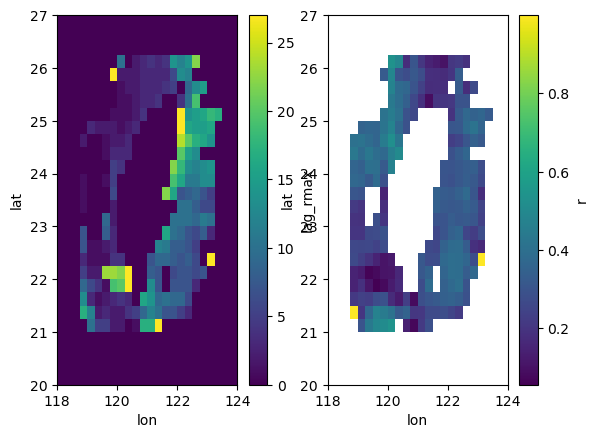

In [57]:
fig,(ax1,ax2) = plt.subplots(1,2)
corr_vel_wind.lag_rmax.plot(ax=ax1)
corr_vel_wind.r.max(dim='lag').plot(ax=ax2)

Text(0.5, 1.0, 'codar geostrophy veering angle')

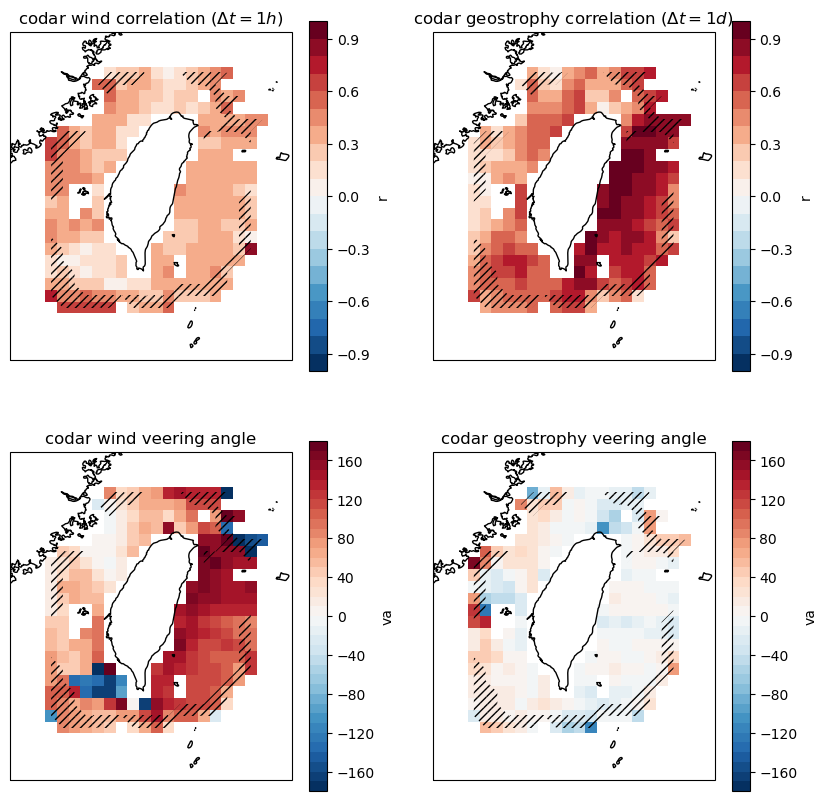

In [8]:
levels_corr = np.arange(-1,1.1,0.1)
levels_veer = np.arange(-180,190,10)
coverage_50 = velocity.coverage.where(velocity.coverage<0.5)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})

corr_vel_wind.r.plot(ax=ax1,levels=levels_corr)
corr_vel_ssh.r.plot(ax=ax2,levels=levels_corr)
corr_vel_wind.va.plot(ax=ax3,levels=levels_veer)
corr_vel_ssh.va.plot(ax=ax4,levels=levels_veer)

coverage_50.plot.contourf(ax=ax1,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(ax=ax2,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(ax=ax3,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(ax=ax4,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())


ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax1.set_title('codar wind correlation ($\Delta t=1h$)')
ax2.set_title('codar geostrophy correlation ($\Delta t=1d$)')
ax3.set_title('codar wind veering angle')
ax4.set_title('codar geostrophy veering angle')
# plt.savefig(figure_path + 'vector_correlations_filtered.png')

# Coherence

https://stackoverflow.com/questions/51258394/compute-coherence-in-python

In [18]:
x=np.linspace(-2500,2500,50000)
nperseg=1000
for ind in range(int(x.size / nperseg)):

    xp = x[ind * nperseg: (ind + 1)*nperseg] 
    # yp = y[ind * nperseg: (ind + 1)*nperseg] 
    xp = xp - np.mean(xp)

In [12]:
type(x.size / nperseg)

float

In [15]:
int(x.size / nperseg)

50

In [16]:
ind * nperseg

49000

In [17]:
(ind + 1)*nperseg

50000

(0.0, 10.0)

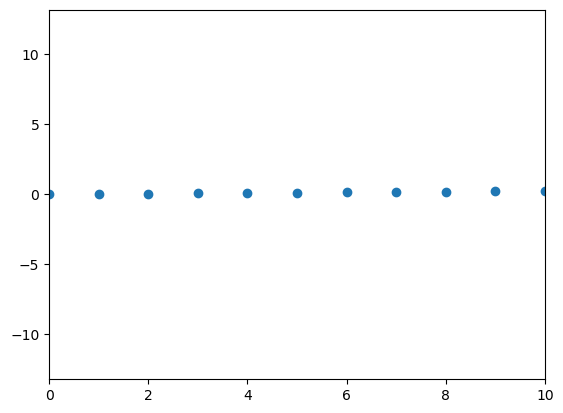

In [31]:
plt.scatter(range(1000),np.fft.fftfreq(1000)*24)
plt.xlim([0,10])

In [97]:
def crossSpectrum(x, y, nperseg=996):

    cross = np.zeros(nperseg, dtype='complex128')
    for ind in range(int(x.size / nperseg)):

        xp = x[ind * nperseg: (ind + 1)*nperseg] 
        yp = y[ind * nperseg: (ind + 1)*nperseg] 
        xp = xp - np.mean(xp)
        yp = yp - np.mean(xp)

        # Do FFT
        freq,cfx,psx,psdx,tx = nufft(xp,xarray_apply=False)
        freq,cfy,psy,psdy,ty = nufft(yp,xarray_apply=False)

        # Get cross spectrum
        cross += cfx.conj()*cfy
    return cross,freq

In [110]:
lat = 23.625
lon = 119.875

data1 = velocity.sel(lat=lat,lon=lon).u_filtered.data
data2 = wind.sel(lat=lat,lon=lon).u10.data

In [98]:
p11,freq=crossSpectrum(data1,data1)
p22,freq=crossSpectrum(data2,data2)
p12,freq=crossSpectrum(data1,data2)

# coherence
coh=np.abs(p12)**2/p11/p22



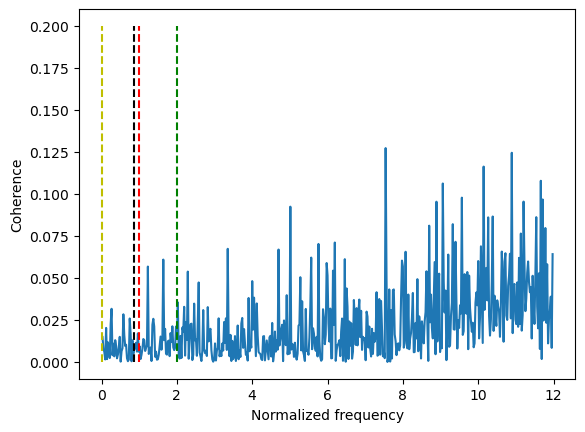

In [81]:
plt.plot((freq*24)[freq > 0], abs(coh)[freq > 0])
plt.xlabel('Normalized frequency')
plt.ylabel('Coherence')
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

ymin,ymax = 0,0.2
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.8e-3],ymin,ymax,color=['y'],linestyle='--',label='seasonal')

In [117]:
freq,cfx,psx1,psdx,tx = nufft(velocity.sel(lat=lat,lon=lon).u_filtered.data,xarray_apply=False)
freq,cfx,psx2,psdx,tx = nufft(velocity.sel(lat=lat,lon=lon).u,xarray_apply=False)
freq2,cfx,psx3,psdx,tx = nufft(velocity_1D.sel(lat=lat,lon=lon).u,xarray_apply=False)

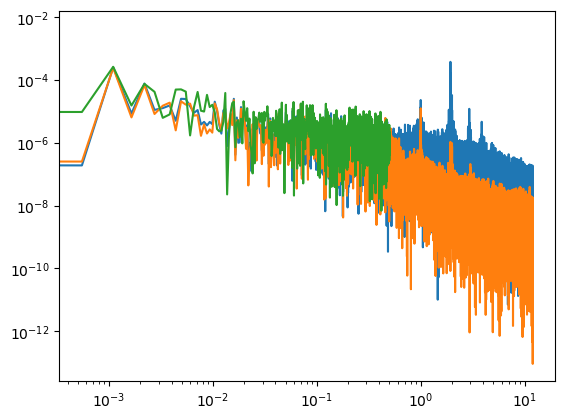

In [118]:
plt.loglog(freq*24,psx2)
plt.loglog(freq*24,psx1)
plt.loglog(freq2,psx3)



In [96]:
(cfx.conj()*cfx)

0.0

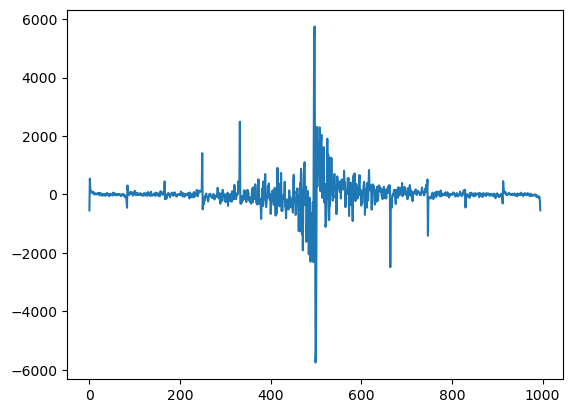

In [102]:
plt.plot(p22.imag)

In [103]:
from matplotlib import mlab

In [106]:
ps1,f = mlab.psd(data2,Fs=1,scale_by_freq=False)

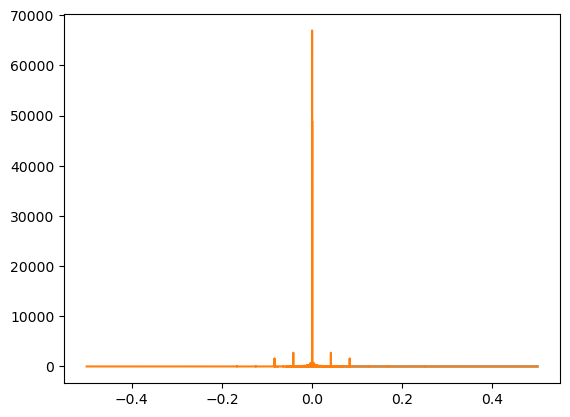

In [109]:
plt.plot(f,ps1)
plt.plot(freq,psdx)